# Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns

In [3]:
db = pd.read_csv("data/player_stats_extended.csv")

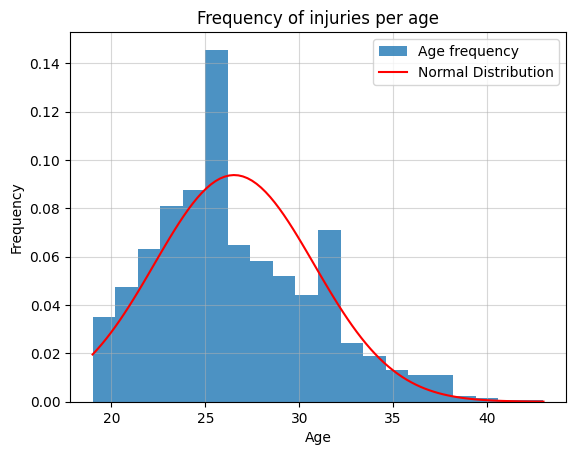

In [3]:
age = db["AGE"]

mu, sigma = np.mean(age), np.std(age)
x = np.linspace(age.min(), age.max(), 100)

plt.grid(alpha=0.5)
plt.hist(age, bins=20, density=True, alpha=0.8, label='Age frequency')
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')
plt.title("Frequency of injuries per age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

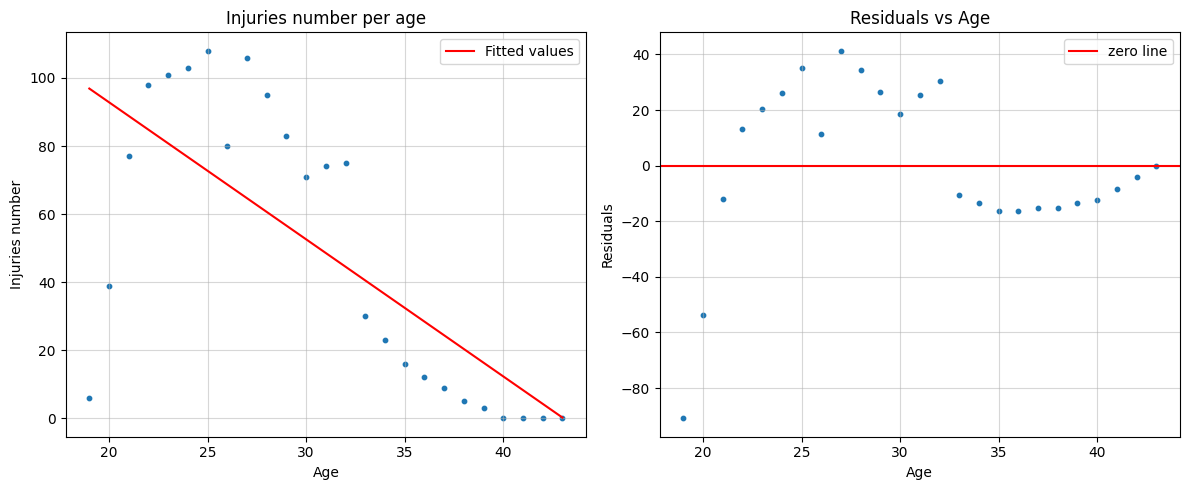

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     22.91
Date:                Tue, 06 May 2025   Prob (F-statistic):           7.94e-05
Time:                        17:33:17   Log-Likelihood:                -119.74
No. Observations:                  25   AIC:                             243.5
Df Residuals:                      23   BIC:                             245.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    173.3946     26.779      6.475      0.0

In [4]:
injuries_age = pd.DataFrame([
    {
    'Age': int(a), 
    'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())])
    }
    for a in sorted(db["AGE"].unique())
])

res = sm.ols('injuries_number ~ Age', data=injuries_age).fit()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
ax1.grid(alpha=0.5)
ax1.scatter(injuries_age['Age'], injuries_age['injuries_number'], s=10)
x = np.linspace(age.min(), age.max(), len(injuries_age))
ax1.plot(x, res.fittedvalues, 'r-', label='Fitted values')
ax1.legend()
ax1.set_title("Injuries number per age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Injuries number")

# Residuals plot
residuals = res.resid
ax2.grid(alpha=0.5)
ax2.scatter(injuries_age['Age'], residuals, s=10)
ax2.axhline(y=0, color='r', linestyle='-', label='zero line')
ax2.set_title("Residuals vs Age")
ax2.set_xlabel("Age")
ax2.set_ylabel("Residuals")
ax2.legend()

plt.tight_layout()
plt.show()

print(res.summary())

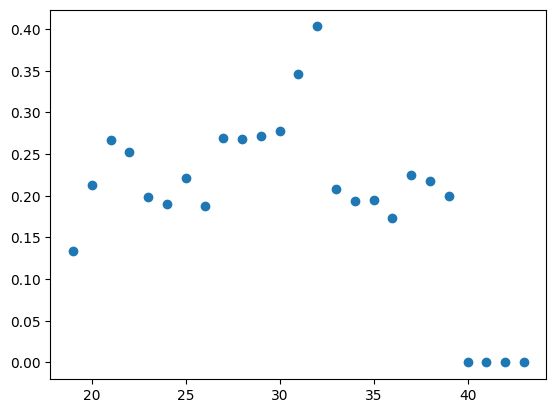

    Age  injuries_number  unique_players
0    19                6              45
1    20               39             183
2    21               77             288
3    22               98             388
4    23              101             508
5    24              103             540
6    25              108             489
7    26               80             425
8    27              106             393
9    28               95             354
10   29               83             306
11   30               71             256
12   31               74             214
13   32               75             186
14   33               30             144
15   34               23             119
16   35               16              82
17   36               12              69
18   37                9              40
19   38                5              23
20   39                3              15
21   40                0              10
22   41                0               4
23   42         

In [5]:
injuries_age = pd.DataFrame([
    {
        'Age': int(a),
        'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
        'unique_players': len(db[db["AGE"] == a]["PLAYER_ID"].unique())
    }
    for a in sorted(db["AGE"].unique())
])

plt.scatter(injuries_age['Age'], injuries_age['injuries_number']/injuries_age['unique_players'])
plt.show()

print(injuries_age)


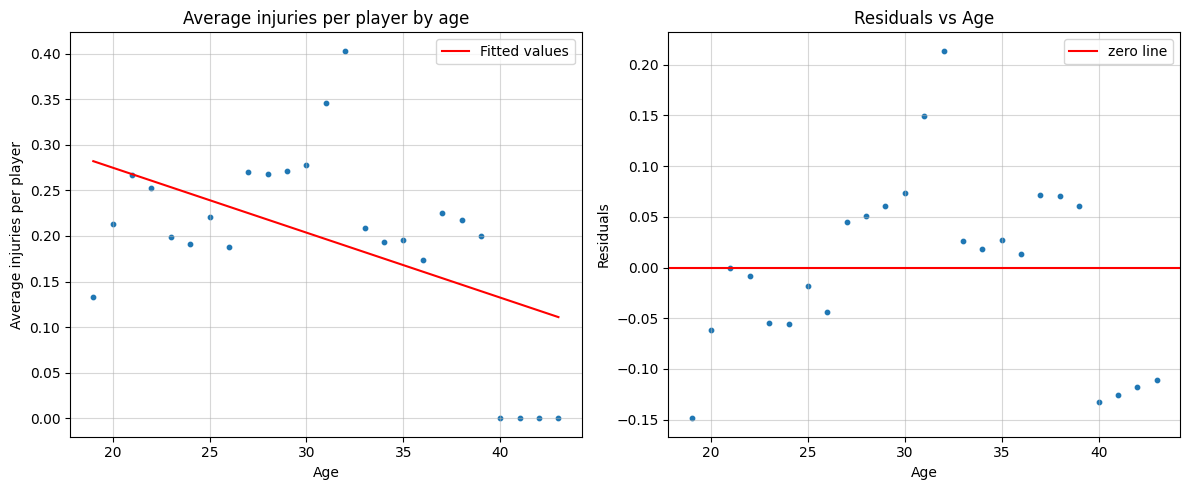

                            OLS Regression Results                            
Dep. Variable:         injuries_ratio   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.946
Date:                Tue, 06 May 2025   Prob (F-statistic):            0.00974
Time:                        17:33:31   Log-Likelihood:                 25.447
No. Observations:                  25   AIC:                            -46.89
Df Residuals:                      23   BIC:                            -44.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4175      0.080      5.188      0.0

In [6]:
injuries_age_stats = pd.DataFrame({
    'Age': injuries_age['Age'],
    'injuries_ratio': injuries_age['injuries_number']/injuries_age['unique_players']
})
res = sm.ols('injuries_ratio ~ Age', data=injuries_age_stats).fit()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
ax1.grid(alpha=0.5)
ax1.scatter(injuries_age['Age'], injuries_age['injuries_number']/injuries_age['unique_players'], s=10)
x = np.linspace(injuries_age['Age'].min(), injuries_age['Age'].max(), len(injuries_age))
ax1.plot(x, res.fittedvalues, 'r-', label='Fitted values')
ax1.legend()
ax1.set_title("Average injuries per player by age")
ax1.set_xlabel("Age")
ax1.set_ylabel("Average injuries per player")

# Residuals plot
residuals = res.resid
ax2.grid(alpha=0.5)
ax2.scatter(injuries_age['Age'], residuals, s=10)
ax2.axhline(y=0, color='r', linestyle='-', label='zero line')
ax2.set_title("Residuals vs Age")
ax2.set_xlabel("Age")
ax2.set_ylabel("Residuals")
ax2.legend()

plt.tight_layout()
plt.show()

print(res.summary())

In [7]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
        'Age': int(a),
        'height': db[db["AGE"] == a]["PLAYER_HEIGHT_INCHES"].mean(),
        'weight': db[db["AGE"] == a]["PLAYER_WEIGHT"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ Age + height + weight', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     16.24
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.09e-05
Time:                        17:33:39   Log-Likelihood:                -113.38
No. Observations:                  25   AIC:                             234.8
Df Residuals:                      21   BIC:                             239.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3333.0903    922.561      3.613      0.0

In [41]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
        'Age': int(a),
        'height': db[db["AGE"] == a]["PLAYER_HEIGHT_INCHES"].mean(),
        'weight': db[db["AGE"] == a]["PLAYER_WEIGHT"].mean(),
        'games_played': db[db["AGE"] == a]["GP"].sum()
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ Age + height + weight + games_played', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     115.1
Date:                Thu, 01 May 2025   Prob (F-statistic):           1.65e-13
Time:                        10:58:18   Log-Likelihood:                -88.640
No. Observations:                  25   AIC:                             187.3
Df Residuals:                      20   BIC:                             193.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      328.0541    442.580      0.741   

In [8]:
# Convert height and weight directly to numeric without string operations
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')
db['DIST_MILES'] = pd.to_numeric(db['DIST_MILES'], errors='coerce')
db['PACE'] = pd.to_numeric(db['PACE'], errors='coerce')
db['AVG_SPEED'] = pd.to_numeric(db['AVG_SPEED'], errors='coerce')

# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'days_missed': db[db["AGE"] == a]["DAYS MISSED"].sum(),
        'pace': db[db["AGE"] == a]["PACE"].mean(),
        'dist_miles': db[db["AGE"] == a]["DIST_MILES"].mean(),
        'avg_speed': db[db["AGE"] == a]["AVG_SPEED"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + days_missed + pace + dist_miles + avg_speed', data=injuries_multiple).fit()

print(res_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     132.9
Date:                Tue, 06 May 2025   Prob (F-statistic):           4.20e-14
Time:                        17:33:54   Log-Likelihood:                -83.591
No. Observations:                  25   AIC:                             179.2
Df Residuals:                      19   BIC:                             186.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -135.2398    131.945     -1.025   

In [38]:
# Create DataFrame with all variables for multiple regression
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'pace': db[db["AGE"] == a]["PACE"].mean(),
        'dist_miles': db[db["AGE"] == a]["DIST_MILES"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + pace + dist_miles', data=injuries_multiple).fit()

print(res_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     166.2
Date:                Thu, 01 May 2025   Prob (F-statistic):           8.67e-15
Time:                        10:52:52   Log-Likelihood:                -88.271
No. Observations:                  25   AIC:                             184.5
Df Residuals:                      21   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -145.2081    149.232     -0.973   

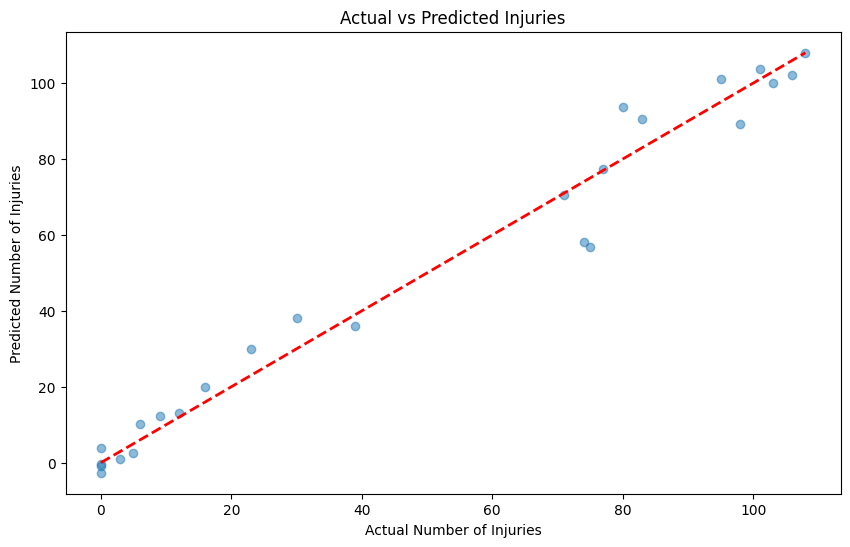

In [9]:
def plot_mult_reg(res_multiple):
    # Create visualization of actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(injuries_multiple['injuries_number'], res_multiple.fittedvalues, alpha=0.5)
    plt.plot([injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            [injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            'r--', lw=2)
    plt.xlabel('Actual Number of Injuries')
    plt.ylabel('Predicted Number of Injuries')
    plt.title('Actual vs Predicted Injuries')
    plt.show()

plot_mult_reg(res_multiple)

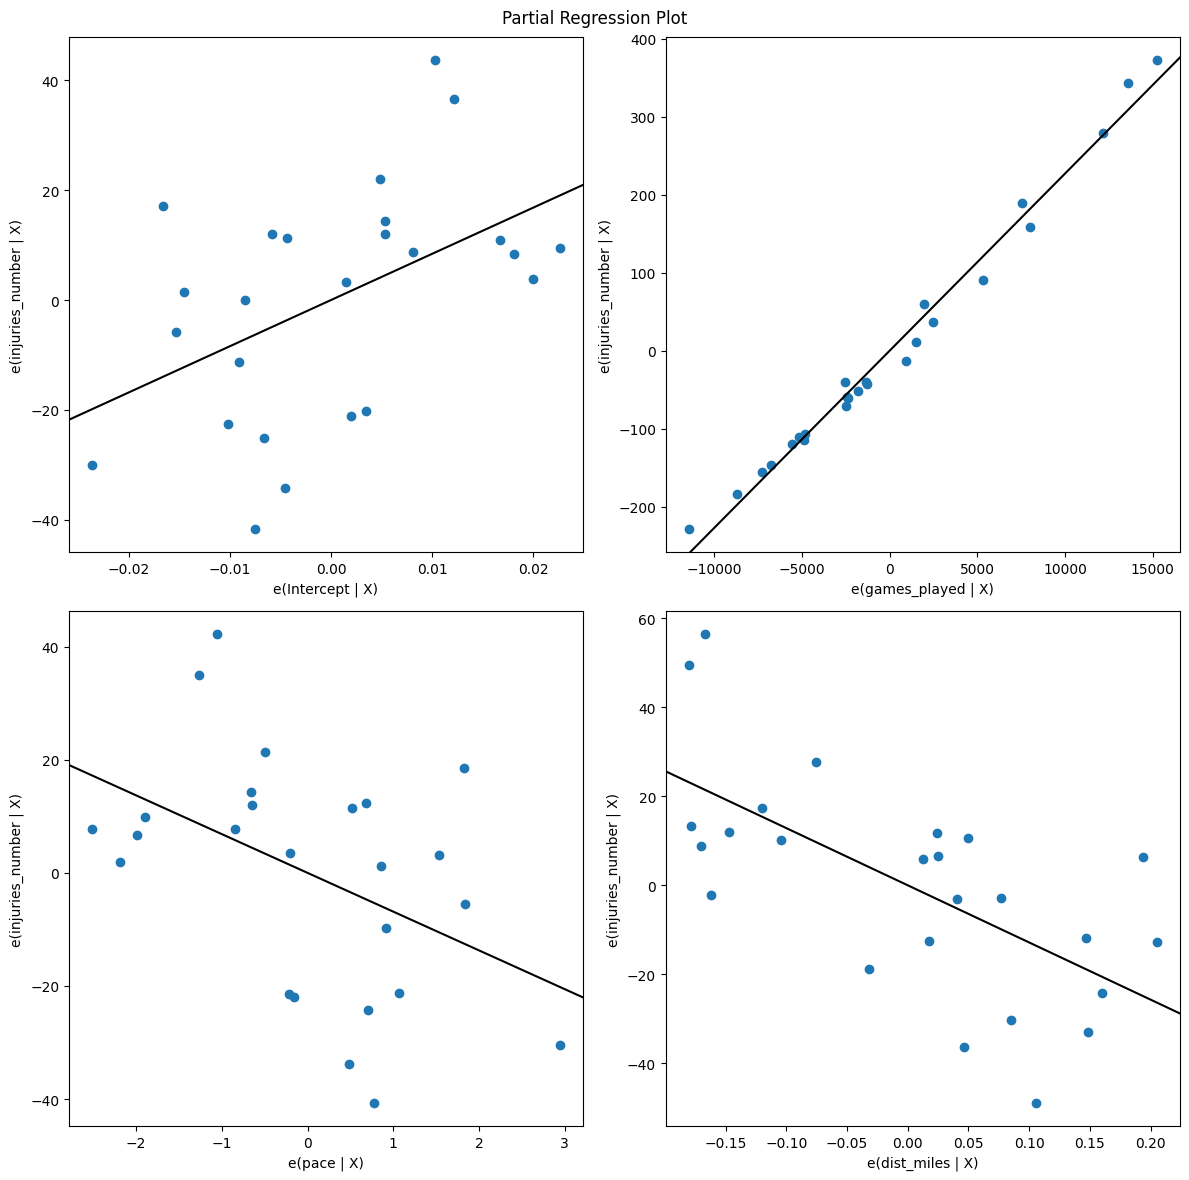

In [18]:
def plot_part_reg(res_multiple):
    # Create partial regression plots
    fig = plt.figure(figsize=(12, 12))
    sma.graphics.plot_partregress_grid(res_multiple, fig=fig)
    plt.tight_layout()
    plt.show()

plot_part_reg(res_multiple)

In [19]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'minutes': db[db["AGE"] == a]["MIN"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

# Perform multiple regression
res_multiple = sm.ols('injuries_number ~ games_played + minutes', data=injuries_multiple).fit()

print(res_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     982.9
Date:                Thu, 01 May 2025   Prob (F-statistic):           3.05e-22
Time:                        10:48:30   Log-Likelihood:                -110.43
No. Observations:                  25   AIC:                             226.9
Df Residuals:                      22   BIC:                             230.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       78.7594     25.305      3.112   

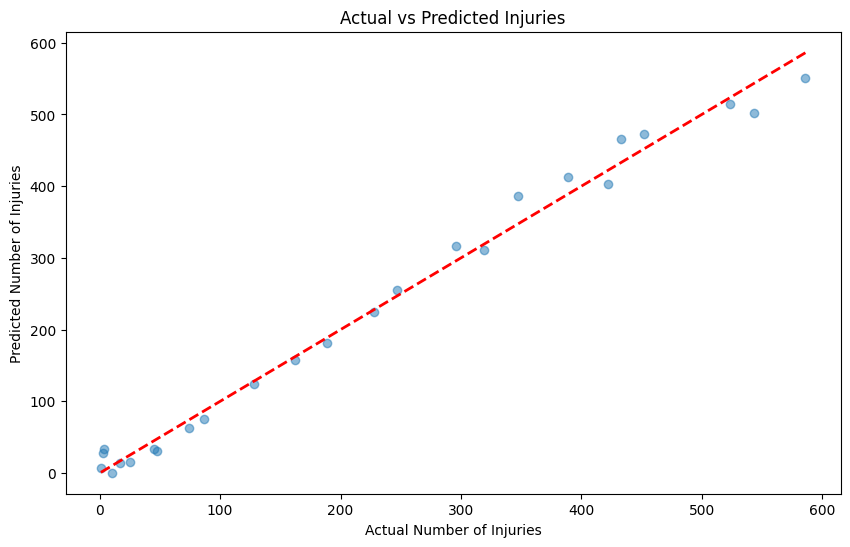

In [20]:
plot_mult_reg(res_multiple)

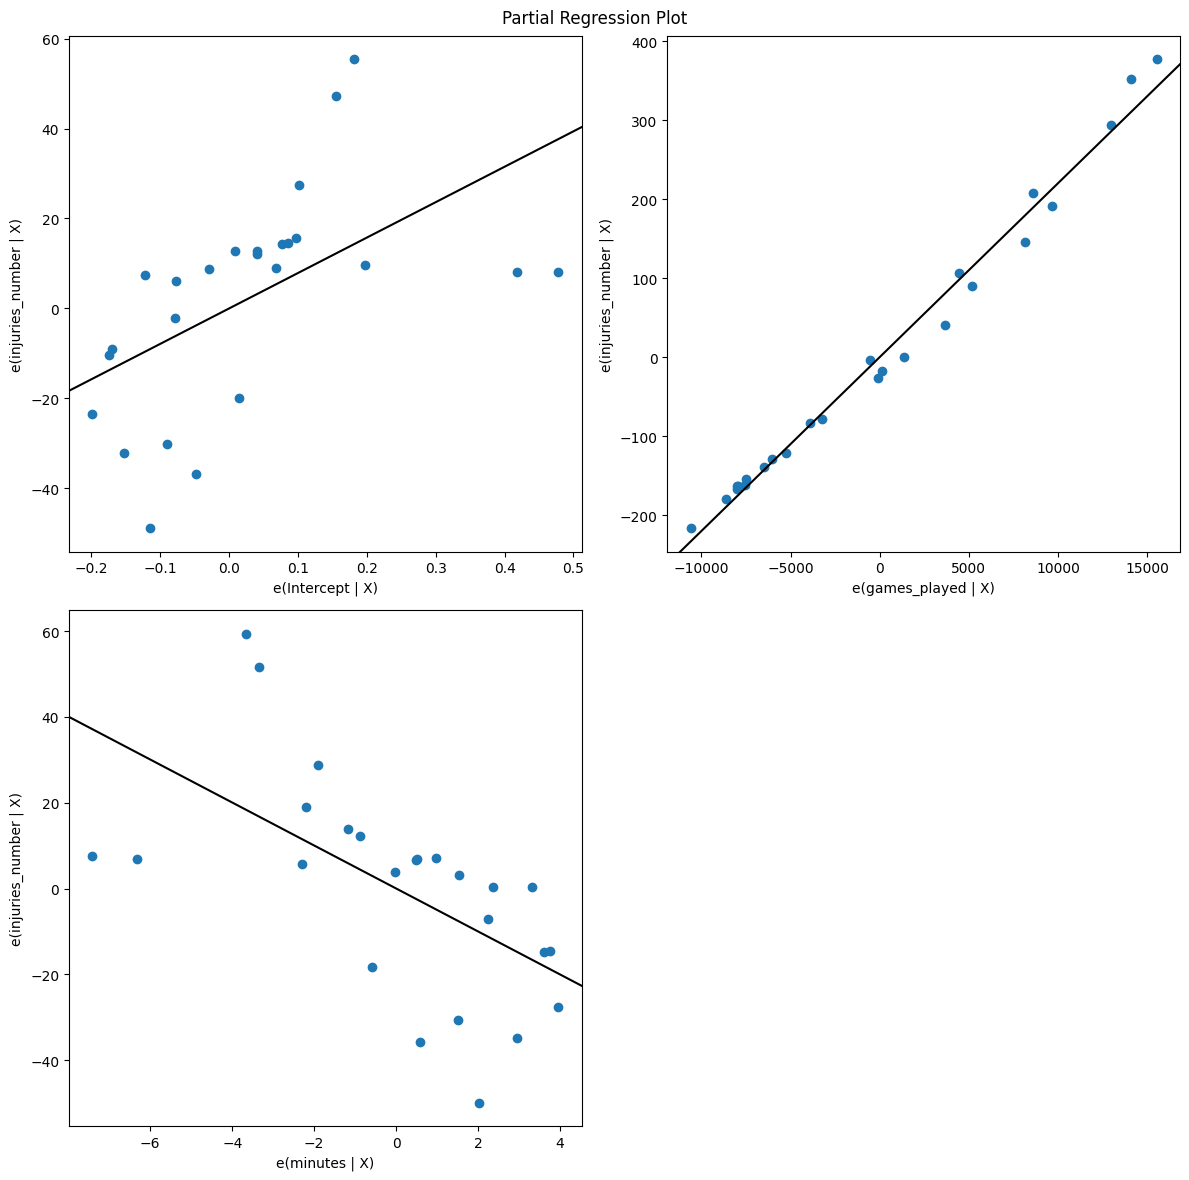

In [21]:
plot_part_reg(res_multiple)

- if older players have a longer recovery time

- split by type of injury and see if predictors are different

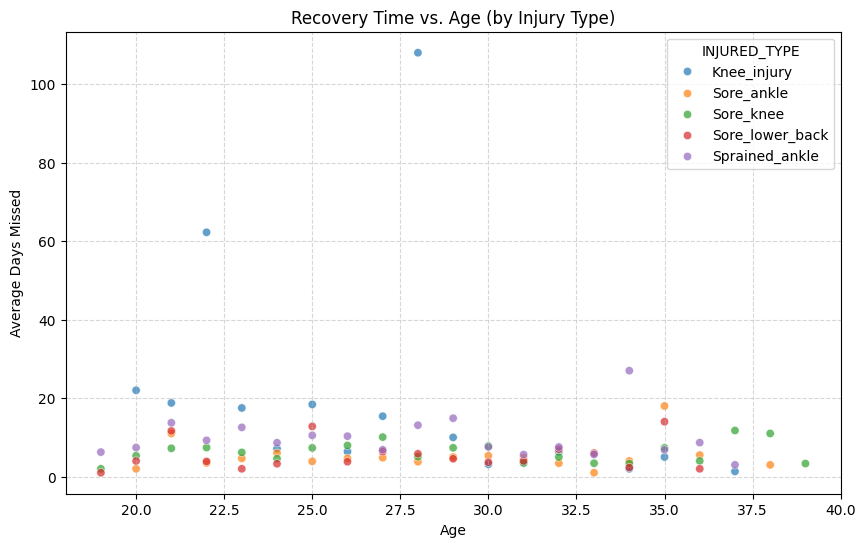

In [44]:
age_recoverytime = db[["AGE", "DAYS MISSED", "INJURED_TYPE"]].copy()
recovery_by_age_and_type = age_recoverytime.groupby(['INJURED_TYPE', 'AGE'])['DAYS MISSED'].mean().reset_index()

age_recoverytime.head()

plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(
    data=recovery_by_age_and_type,
    x='AGE',
    y='DAYS MISSED',
    hue='INJURED_TYPE',
    alpha=0.7  # Adjust transparency for better readability
)

# Add title and labels
plt.title("Recovery Time vs. Age (by Injury Type)")
plt.xlabel("Age")
plt.ylabel("Average Days Missed")

# Show grid for better visualization
plt.grid(True, linestyle="--", alpha=0.5)

# Display the plot
plt.show()

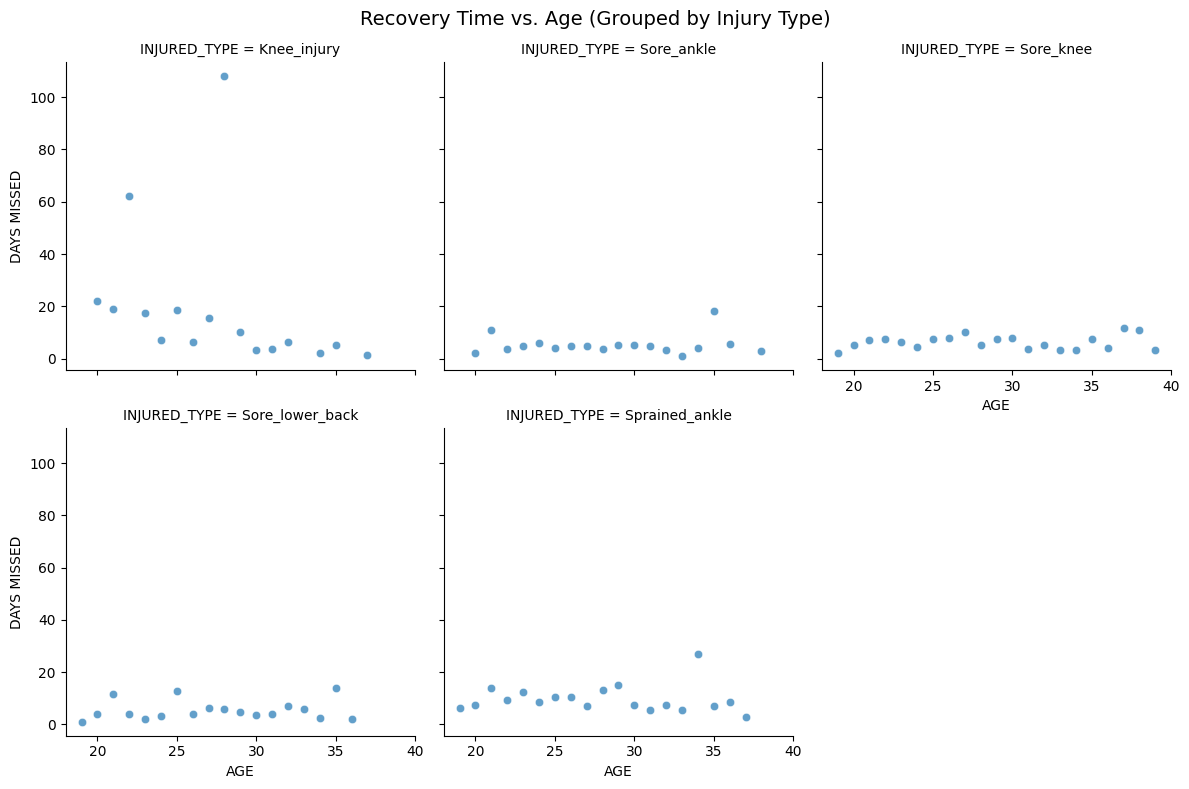

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the FacetGrid with each injury type as a separate plot
g = sns.FacetGrid(recovery_by_age_and_type, col="INJURED_TYPE", col_wrap=3, height=4, sharex=True, sharey=True)

# Map scatter plots onto each subplot
g.map_dataframe(sns.scatterplot, x="AGE", y="DAYS MISSED", alpha=0.7)

# Add title to the overall figure
g.fig.suptitle("Recovery Time vs. Age (Grouped by Injury Type)", fontsize=14)

# Adjust layout
g.tight_layout()

# Show the plots
plt.show()

In [4]:
# Convert all relevant numeric columns to numeric type
db['PLAYER_HEIGHT_INCHES'] = pd.to_numeric(db['PLAYER_HEIGHT_INCHES'], errors='coerce')
db['PLAYER_WEIGHT'] = pd.to_numeric(db['PLAYER_WEIGHT'], errors='coerce')
db['DIST_MILES'] = pd.to_numeric(db['DIST_MILES'], errors='coerce')
db['PACE'] = pd.to_numeric(db['PACE'], errors='coerce')
db['AVG_SPEED'] = pd.to_numeric(db['AVG_SPEED'], errors='coerce')
db['GP'] = pd.to_numeric(db['GP'], errors='coerce')
db['MIN'] = pd.to_numeric(db['MIN'], errors='coerce')
db['POSS'] = pd.to_numeric(db['POSS'], errors='coerce')
db['FGA_PG'] = pd.to_numeric(db['FGA_PG'], errors='coerce')
db['PULL_UP_FGA'] = pd.to_numeric(db['PULL_UP_FGA'], errors='coerce')
db['PULL_UP_FG3A'] = pd.to_numeric(db['PULL_UP_FG3A'], errors='coerce')

injuries_parameters = {
    "Sprained_ankle": ["games_played", "pull_up_fga", "pull_up_fg3a"],
    "Sore_knee": ["games_played", "poss"],
    "Knee_injury": ["games_played","poss", "fga_pg", "pull_up_fga", "pull_up_fg3a"],
    "Sore_lower_back": ["games_played","minutes", "poss", "pull_up_fga", "pull_up_fg3a"],
    "Sore_ankle": ["games_played", "poss"],
}

def plot_mult_reg_2(res_multiple, injuries_multiple, injury):
    # Create visualization of actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(injuries_multiple['injuries_number'], res_multiple.fittedvalues, alpha=0.5)
    plt.plot([injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            [injuries_multiple['injuries_number'].min(), injuries_multiple['injuries_number'].max()], 
            'r--', lw=2)
    plt.xlabel('Actual Number of Injuries')
    plt.ylabel('Predicted Number of Injuries')
    plt.title(f'Actual vs Predicted Injuries ({injury})')
    plt.show()

def mult_regression(db, injury):
    # Create DataFrame with all variables for multiple regression
    injuries_multiple = pd.DataFrame([
        {
            'injuries_number': len(db[db["AGE"] == a]),
            'games_played': db[db["AGE"] == a]["GP"].sum(),
            'minutes': db[db["AGE"] == a]["MIN"].mean(),
            'poss': db[db["AGE"] == a]["POSS"].mean(),
            'fga_pg': db[db["AGE"] == a]["FGA_PG"].mean(),
            'pull_up_fga': db[db["AGE"] == a]["PULL_UP_FGA"].mean(),
            'pull_up_fg3a': db[db["AGE"] == a]["PULL_UP_FG3A"].mean(),
        }
        for a in sorted(db["AGE"].unique())
    ])

    # Perform multiple regression
    params = " + ".join(injuries_parameters[injury])
    res_multiple = sm.ols(f'injuries_number ~ {params}', data=injuries_multiple).fit()

    return res_multiple, injuries_multiple

Sprained_ankle
                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     531.8
Date:                Thu, 01 May 2025   Prob (F-statistic):           1.90e-15
Time:                        11:35:22   Log-Likelihood:                -40.109
No. Observations:                  19   AIC:                             88.22
Df Residuals:                      15   BIC:                             92.00
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3837      1.73

/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were giv

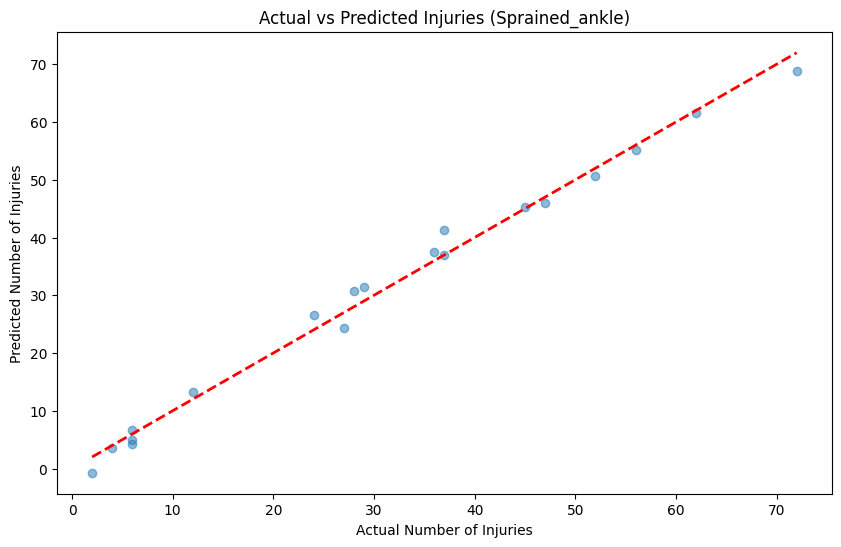

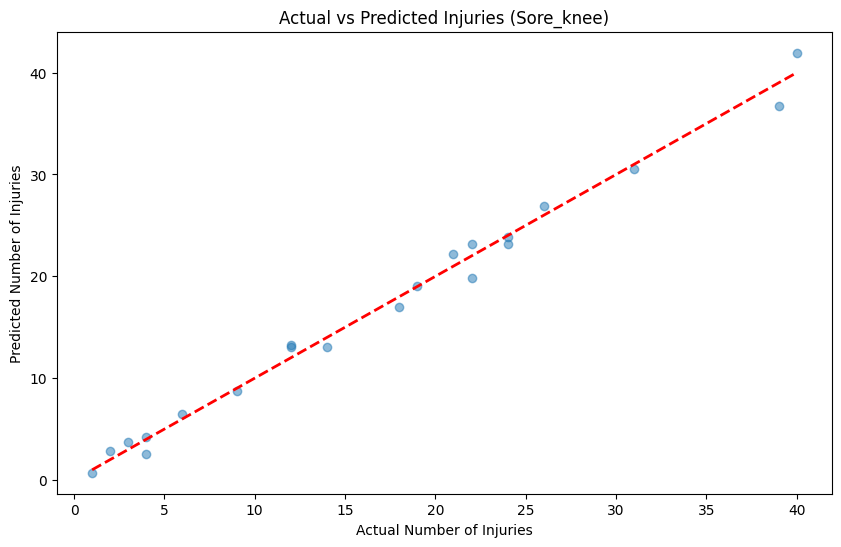

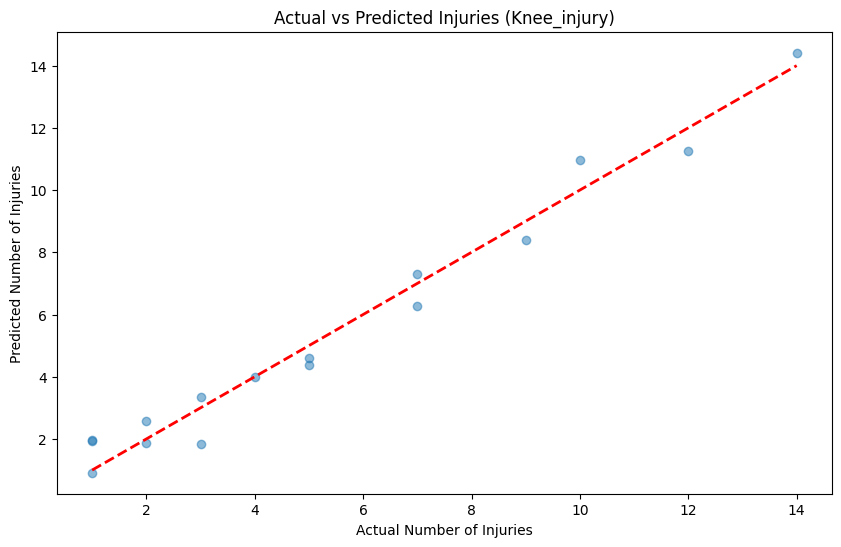

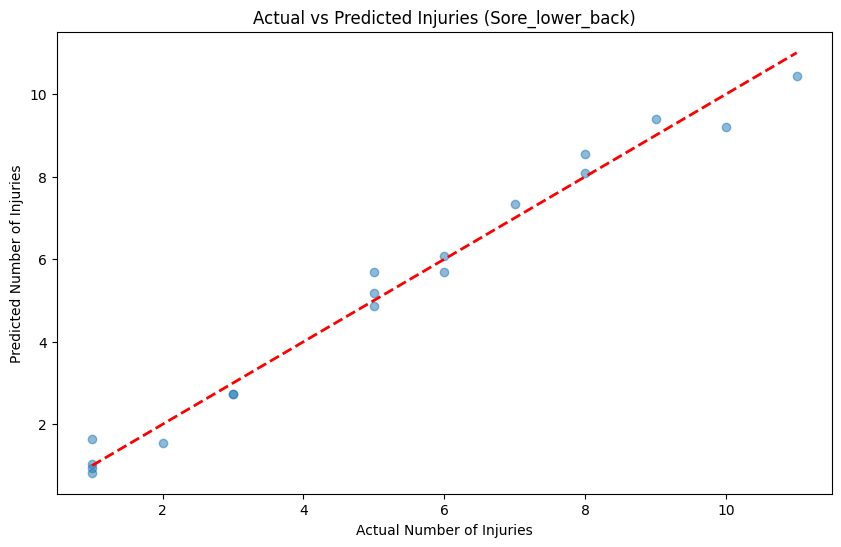

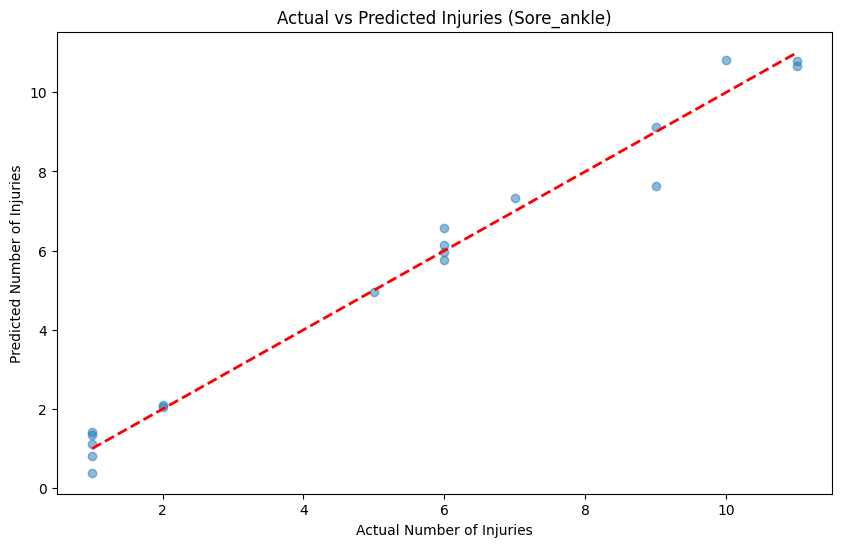

In [73]:
injuries_types = db[db["INJURED_TYPE"].notna()]["INJURED_TYPE"].unique()

injuries_res = {}
injuries_multiple = {}

for injury in injuries_types:
    injuries_res[injury], injuries_multiple[injury] = mult_regression(db[db["INJURED_TYPE"] == injury], injury)
    print(injury)
    print(injuries_res[injury].summary())
    print("\n-----------------------\n")
    
for (injury, res) in injuries_res.items():
    plot_mult_reg_2(injuries_res[injury], injuries_multiple[injury], injury)

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Load your player-level data
# db should contain: PLAYER_ID, AGE, GP, MIN, INJURED_TYPE
player_data = db.copy()

# Create proper injury indicators at player level
player_data['was_injured'] = (player_data['INJURED_TYPE'].notna()).astype(int)

# Calculate player-level exposure (total games played)
player_level = player_data.groupby('PLAYER_ID').agg({
    'AGE': 'mean',
    'GP': 'sum',
    'MIN': 'mean',
    'was_injured': 'max',  # 1 if player had any injury
    'INJURED_TYPE': 'count'  # count of injury events
}).rename(columns={'INJURED_TYPE': 'injury_count'})

# Split at player level (not age level)
train_players, test_players = train_test_split(
    player_level.reset_index(),
    test_size=0.2,
    random_state=42,
    stratify=player_level['was_injured']  # Maintain injury ratio
)

# Model 1: Logistic Regression for injury probability
print("\n=== Logistic Regression (Injury Probability) ===")
logit_model = sm.Logit(
    train_players['was_injured'],
    sm.add_constant(train_players[['AGE', 'GP', 'MIN']])
).fit()
print(logit_model.summary())

# Model 2: Negative Binomial for injury counts (handles overdispersion)
print("\n=== Negative Binomial (Injury Counts) ===")
nb_model = sm.GLM(
    train_players['injury_count'],
    sm.add_constant(train_players[['AGE', 'GP', 'MIN']]),
    family=sm.families.NegativeBinomial(),
    exposure=train_players['GP']  # Account for playing time
).fit()
print(nb_model.summary())

# Model 3: Linear model for age effects (only if needed)
print("\n=== OLS (Age Effects on Injury Rate) ===")
train_players['injury_rate'] = train_players['injury_count'] / train_players['GP']
ols_model = sm.OLS(
    train_players['injury_rate'],
    sm.add_constant(train_players[['AGE', 'MIN']])  # GP already accounted for
).fit()
print(ols_model.summary())

# Evaluate models on test data
def evaluate_model(model, test_data, model_type):
    if model_type == "logit":
        preds = model.predict(sm.add_constant(test_data[['AGE', 'GP', 'MIN']]))
        actual = test_data['was_injured']
        # Calculate classification metrics
        from sklearn.metrics import roc_auc_score, accuracy_score
        print(f"AUC: {roc_auc_score(actual, preds):.3f}")
        print(f"Accuracy: {accuracy_score(actual, (preds > 0.5).astype(int)):.3f}")
    
    elif model_type == "nb":
        preds = model.predict(
            sm.add_constant(test_data[['AGE', 'GP', 'MIN']]),
            exposure=test_data['GP']
        )
        actual = test_data['injury_count']
        # Calculate count model metrics
        mse = np.mean((actual - preds) ** 2)
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {np.sqrt(mse):.2f}")
    
    elif model_type == "ols":
        preds = model.predict(sm.add_constant(test_data[['AGE', 'MIN']]))
        actual = test_data['injury_count'] / test_data['GP']
        r2 = model.rsquared
        print(f"R-squared: {r2:.3f}")
        print(f"RMSE: {np.sqrt(np.mean((actual - preds)**2)):.4f}")

print("\n=== Test Set Evaluation ===")
evaluate_model(logit_model, test_players, "logit")
evaluate_model(nb_model, test_players, "nb")
evaluate_model(ols_model, test_players, "ols")

# Descriptive statistics
print("\n=== Descriptive Statistics ===")
print("Injury Prevalence:")
print(f"- {player_level['was_injured'].mean():.1%} players experienced injuries")
print("\nInjury Counts:")
print(player_level['injury_count'].describe())
print("\nAge Distribution:")
print(player_level['AGE'].describe())


=== Logistic Regression (Injury Probability) ===
Optimization terminated successfully.
         Current function value: 0.372572
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            was_injured   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1108
Method:                           MLE   Df Model:                            3
Date:                Tue, 06 May 2025   Pseudo R-squ.:                  0.3766
Time:                        21:11:45   Log-Likelihood:                -414.30
converged:                       True   LL-Null:                       -664.62
Covariance Type:            nonrobust   LLR p-value:                3.467e-108
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9801      0.812      4.900      0.000    

/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


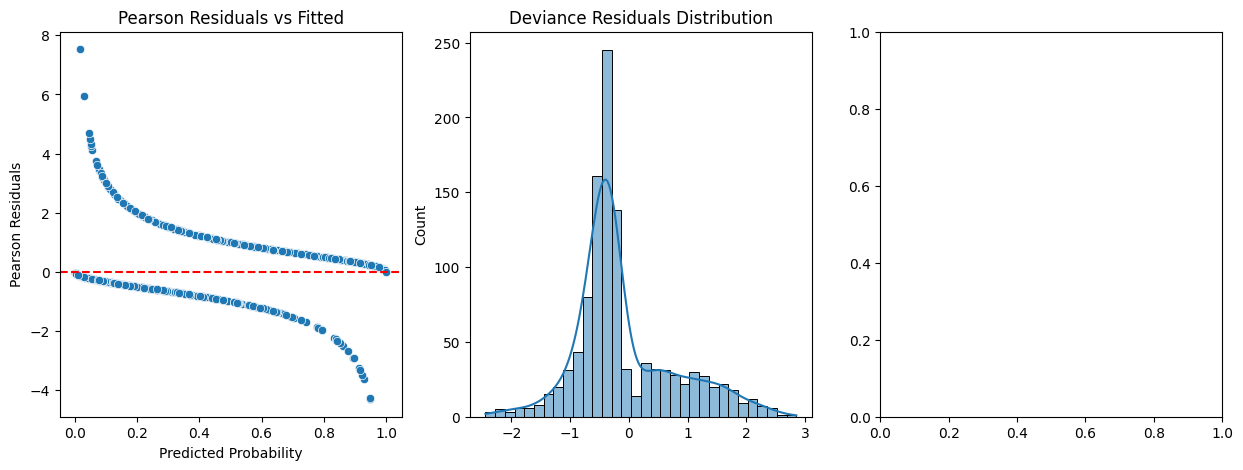

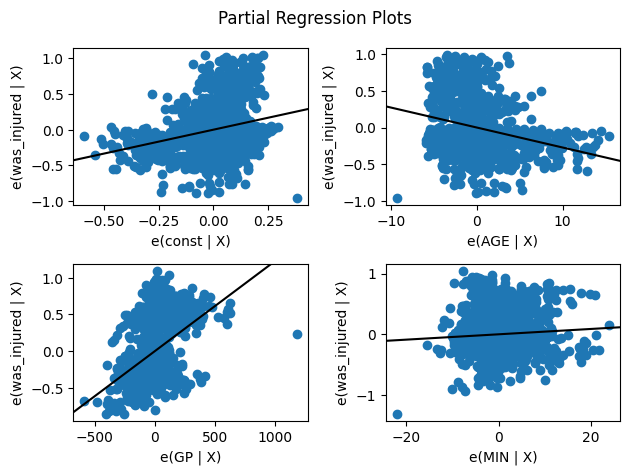

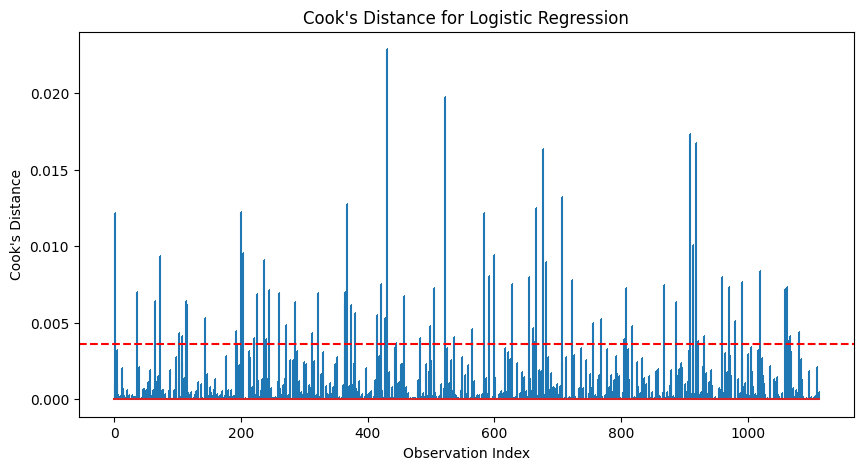


Goodness-of-fit (grouped predictions vs actual):
                                    y            prob
                                  sum count      mean
group                                                
(-0.00023000000000000006, 0.0276]   2   112  0.014193
(0.0276, 0.0515]                    4   111  0.040545
(0.0515, 0.0724]                    4   111  0.061170
(0.0724, 0.102]                     9   111  0.087008
(0.102, 0.148]                     11   111  0.123126
(0.148, 0.223]                     19   111  0.181679
(0.223, 0.34]                      37   111  0.277170
(0.34, 0.56]                       55   111  0.445093
(0.56, 0.835]                      79   111  0.694914
(0.835, 1.0]                       97   112  0.922520


/var/folders/rf/ct0j035d2vs6n50jvjxy22480000gn/T/ipykernel_80554/1759545713.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('group')


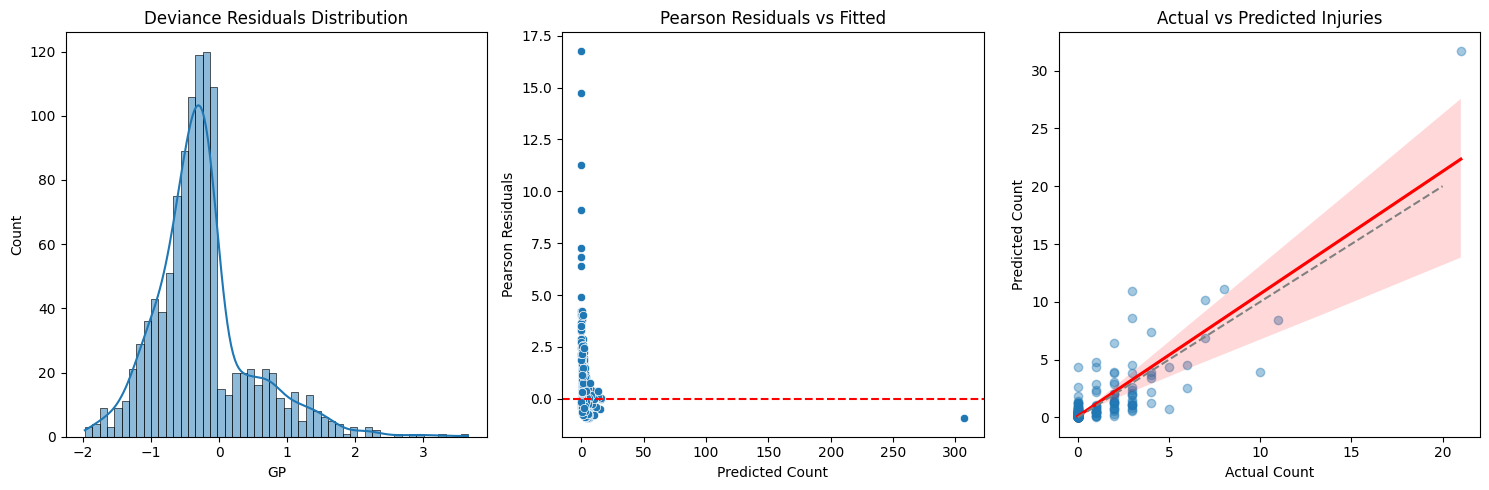


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       795
           1       0.77      0.61      0.68       317

    accuracy                           0.84      1112
   macro avg       0.81      0.77      0.78      1112
weighted avg       0.83      0.84      0.83      1112



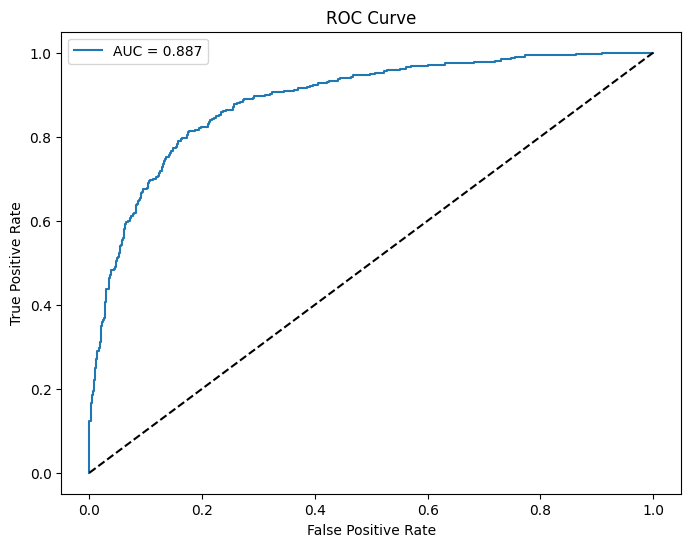

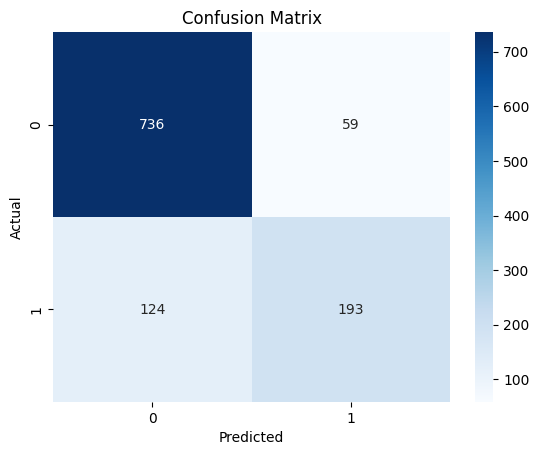


Negative Binomial Overdispersion Test:
Pearson Chi²/DF: 1.359
Values >1 indicate overdispersion (NB is appropriate)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import plot_partregress_grid, influence_plot
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

# 1. Logistic Regression Diagnostics
plt.figure(figsize=(15, 5))

# Pearson residuals vs predicted
plt.subplot(131)
sns.scatterplot(x=logit_model.predict(), y=logit_model.resid_pearson)
plt.axhline(0, color='red', linestyle='--')
plt.title('Pearson Residuals vs Fitted')
plt.xlabel('Predicted Probability')
plt.ylabel('Pearson Residuals')

# Deviance residuals
plt.subplot(132)
sns.histplot(logit_model.resid_dev, kde=True)
plt.title('Deviance Residuals Distribution')

# Partial regression plots
plt.subplot(133)
fig = plot_partregress_grid(logit_model)
plt.suptitle('Partial Regression Plots')
plt.tight_layout()
plt.show()

# Influence measures
logit_influence = logit_model.get_influence()
cooks_distance = logit_influence.cooks_distance[0]

plt.figure(figsize=(10, 5))
plt.stem(cooks_distance, markerfmt=",")
plt.axhline(y=4/len(train_players), color='r', linestyle='--')
plt.title("Cook's Distance for Logistic Regression")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()

# Alternative to Hosmer-Lemeshow test
def hosmer_lemeshow(y_true, y_prob, n_groups=10):
    df = pd.DataFrame({'y': y_true, 'prob': y_prob})
    df['group'] = pd.qcut(df['prob'], n_groups, duplicates='drop')
    grouped = df.groupby('group')
    return grouped.agg({'y': ['sum', 'count'], 'prob': 'mean'})

print("\nGoodness-of-fit (grouped predictions vs actual):")
print(hosmer_lemeshow(train_players['was_injured'], logit_model.predict()))

# 2. Negative Binomial Diagnostics
plt.figure(figsize=(15, 5))

# Deviance residuals
plt.subplot(131)
sns.histplot(nb_model.resid_deviance, kde=True)
plt.title("Deviance Residuals Distribution")

# Pearson residuals vs predicted
plt.subplot(132)
sns.scatterplot(x=nb_model.predict(), y=nb_model.resid_pearson)
plt.axhline(0, color='red', linestyle='--')
plt.title("Pearson Residuals vs Fitted")
plt.xlabel("Predicted Count")
plt.ylabel("Pearson Residuals")

# Actual vs predicted plot
plt.subplot(133)
pred_counts = nb_model.predict(
    sm.add_constant(test_players[['AGE', 'GP', 'MIN']]),
    exposure=test_players['GP']
)
sns.regplot(x=test_players['injury_count'], y=pred_counts, 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.plot([0,20], [0,20], '--', color='gray')
plt.title("Actual vs Predicted Injuries")
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.tight_layout()
plt.show()

# 3. Model Performance Metrics
# Classification report for logistic model
y_pred = (logit_model.predict() > 0.5).astype(int)
print("\nLogistic Regression Classification Report:")
print(classification_report(train_players['was_injured'], y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(train_players['was_injured'], logit_model.predict())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(train_players["was_injured"], logit_model.predict()):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(train_players['was_injured'], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Overdispersion test for negative binomial
print("\nNegative Binomial Overdispersion Test:")
print(f"Pearson Chi²/DF: {np.sum(nb_model.resid_pearson**2)/nb_model.df_resid:.3f}")
print("Values >1 indicate overdispersion (NB is appropriate)")